In [14]:
import pandas as pd
import time
import numpy as np
import copy
import glob
import sys, os
import os
import shutil

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.metrics import precision_score, recall_score
import pickle
from sklearn import preprocessing
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment,ACSIncome
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import os
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import pandas as pd
from scipy.stats import multivariate_normal
import torch, random, copy, os
from collections import OrderedDict


In [15]:
 class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x



In [16]:

source_path1="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model_FF.pt"
source_path2="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model_FA.pt"



path_1="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model_FF.pt"
path_2="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model_FA.pt"

print("Deleting old models-----")
if os.path.exists(source_path1):
    os.remove(path_1)
else:
    print(f"{path_1} does not exist.\n\n")

# Remove the second file
if os.path.exists(source_path2):
    os.remove(path_2)
else:
    print(f"{path_2} does not exist.")

Deleting old models-----
/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model_FF.pt does not exist.




In [17]:

print("copying models to dir----")
if os.path.exists(source_path1):
    shutil.copy(source_path1, path_1)
    
else:
    print(f"{source_path1} does not exist, \n\n")

# Copy the second file if it exists
if os.path.exists(source_path2):
    shutil.copy(source_path2, path_2)
    
else:
    print(f"{source_path2} does not exist,")

copying models to dir----
/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model_FF.pt does not exist, 




In [18]:
temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/"

with open(temp_path_data+"/valid_testing_client.pkl", "rb") as f:
    valset = pickle.load(f)
 
with open(temp_path_data+"/testing_client.pkl", "rb") as f:
    testset  = pickle.load(f)


import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    # CUDA is not available
    print("CUDA is not available. Running on CPU.")


CUDA is available.


In [19]:
model=DeepNet()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

# FAIR FED

In [20]:
model.load_state_dict(torch.load(path_1))
model.eval()

DeepNet(
  (layer1): Linear(in_features=14, out_features=512, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=256, out_features=60, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [21]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
pr_FF=[]
rc_FF=[]
ac_FF=[]
selected_clients = [0, 1, 2, 3]
client_metrics = []

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_ff = pd.DataFrame(client_metrics)
df_ff


Global Testing Accuracy: 82.24912%
Global Precision: 79.40848%
Global Recall: 78.87949%


Global Testing Accuracy: 80.84977%
Global Precision: 74.06368%
Global Recall: 79.51693%


Global Testing Accuracy: 80.94846%
Global Precision: 74.59784%
Global Recall: 79.63887%


Global Testing Accuracy: 80.90305%
Global Precision: 74.75861%
Global Recall: 79.83394%




,Client ID,Accuracy,Precision,Recall
0,0,0.822491,0.794085,0.788795
1,1,0.808498,0.740637,0.795169
2,2,0.809485,0.745978,0.796389
3,3,0.809031,0.747586,0.798339


# FedAVG

In [22]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

path_2="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model_FA.pt"
diff_path="/home/chiragapandav/Downloads/Hiwi/pFedLA_Folktable/temp/my_model/global_model.pt"


model=DeepNet()
model.load_state_dict(torch.load(path_2))
model.eval()
client_metrics=[]

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")
    
    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_FA = pd.DataFrame(client_metrics)
df_FA

Global Testing Accuracy: 79.94457%
Global Precision: 75.51574%
Global Recall: 78.46955%



Global Testing Accuracy: 78.47582%
Global Precision: 70.19567%
Global Recall: 79.38650%



Global Testing Accuracy: 78.68208%
Global Precision: 70.89772%
Global Recall: 79.50896%



Global Testing Accuracy: 78.71250%
Global Precision: 71.16930%
Global Recall: 79.80138%





,Client ID,Accuracy,Precision,Recall
0,0,0.799446,0.755157,0.784696
1,1,0.784758,0.701957,0.793865
2,2,0.786821,0.708977,0.795090
3,3,0.787125,0.711693,0.798014


# classical model

In [23]:
 
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


In [24]:
temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/"


with open(temp_path_data+"/Normal_training_data.pkl", "rb") as f:
    nor_trainData = pickle.load(f)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=DeepNet()

model = model.to(device)
criterion = criterion.to(device)

In [15]:
# num_epochs=10
# for epoch in range(num_epochs):
#     # Set the model to training mode
#     model.train()

#     for inputs, labels, sens in nor_trainData:
        
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs).to(device)
#         loss = criterion(outputs, labels.float())
#         loss.backward()
#         optimizer.step()

In [16]:
# torch.save(model.state_dict(), "normal_model.pth")

In [26]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

model=DeepNet()
model.load_state_dict(torch.load("normal_model.pth"))
model.eval()

client_metrics=[]
# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_CD = pd.DataFrame(client_metrics)
df_CD

Global Testing Accuracy: 42.69618%
Global Precision: 42.69618%
Global Recall: 100.00000%



Global Testing Accuracy: 39.62466%
Global Precision: 39.62466%
Global Recall: 100.00000%



Global Testing Accuracy: 40.12552%
Global Precision: 40.12552%
Global Recall: 100.00000%



Global Testing Accuracy: 40.52740%
Global Precision: 40.52740%
Global Recall: 100.00000%





,Client ID,Accuracy,Precision,Recall
0,0,0.426962,0.426962,1.0
1,1,0.396247,0.396247,1.0
2,2,0.401255,0.401255,1.0
3,3,0.405274,0.405274,1.0


In [27]:
df_ff

,Client ID,Accuracy,Precision,Recall
0,0,0.822491,0.794085,0.788795
1,1,0.808498,0.740637,0.795169
2,2,0.809485,0.745978,0.796389
3,3,0.809031,0.747586,0.798339


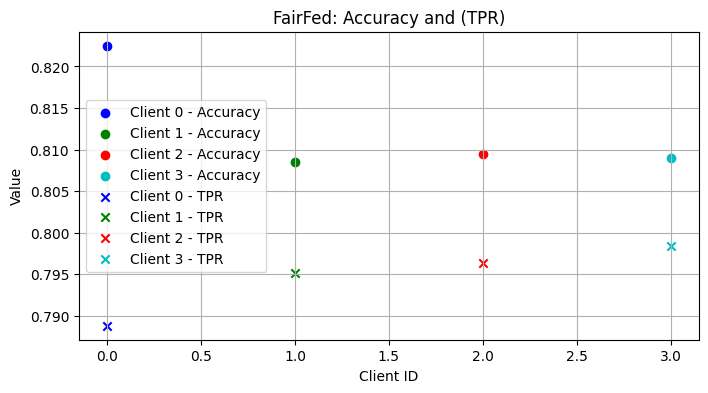

In [28]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_ff['Client ID']):
    ax.scatter(client, df_ff['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_ff['Client ID']):
    ax.scatter(client, df_ff['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('FairFed: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

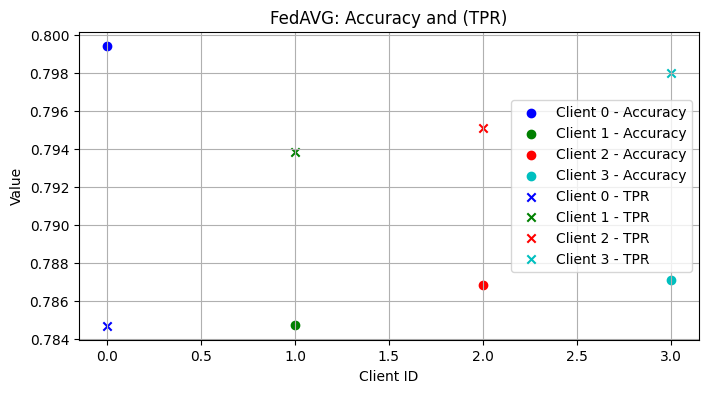

In [29]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_FA['Client ID']):
    ax.scatter(client, df_FA['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_FA['Client ID']):
    ax.scatter(client, df_FA['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('FedAVG: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

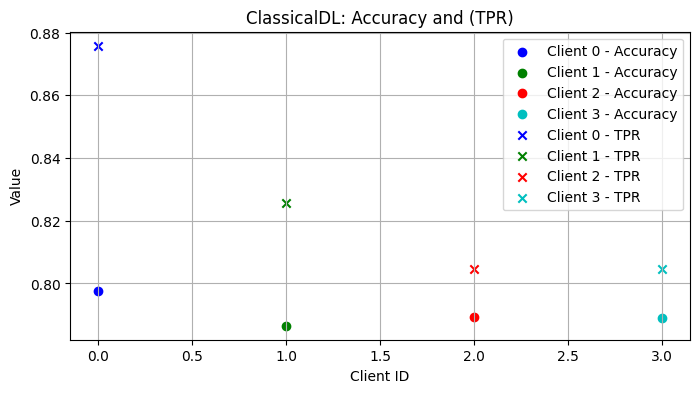

In [33]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('ClassicalDL: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

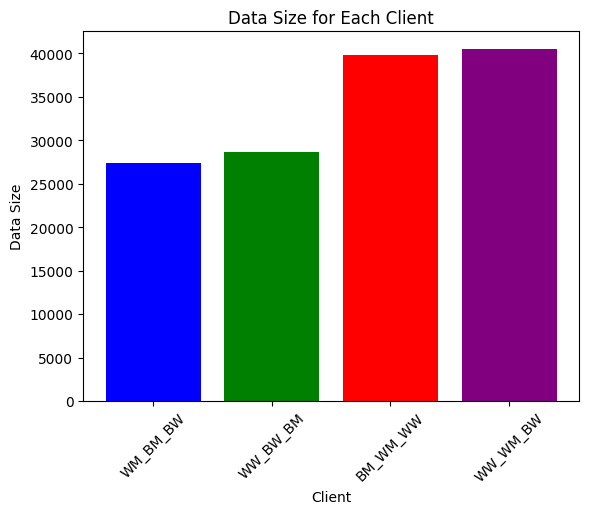

In [27]:
import matplotlib.pyplot as plt

# Data
client_names = ['Client 1', 'Client 2', 'Client 3', 'Client 4']
data_sizes = [27424, 28685, 39815, 40480]

# Dictionary to map old names to new names
name_mapping = {
    'Client 1': 'WM_BM_BW',
    'Client 2': 'WW_BW_BM',
    'Client 3': 'BM_WM_WW',
    'Client 4': 'WW_WM_BW'
}

client_names = [name_mapping[name] for name in client_names]

# Create a bar chart
plt.bar(client_names, data_sizes, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Client')
plt.ylabel('Data Size')
plt.title('Data Size for Each Client')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


# individual client performance

In [ ]:
temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/data_fairFed"

 
with open(temp_path_data+"/clients_testing_wrong.pkl", "rb") as f:
    testset  = pickle.load(f)

     
# testset = testset[client_id]

In [31]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

model=DeepNet()

models_directory = "/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/"

client_metrics=[]
# Assuming model and criterion are already defined and loaded onto the GPU

criterion = criterion.to(device)

for i in range(len(selected_clients)):
    model_path = os.path.join(models_directory, f"client_{i}_model.pth")  
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    print("client::",i)
    model = model.to(device)
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_CD = pd.DataFrame(client_metrics)
df_CD

client:: 0
Global Testing Accuracy: 79.76954%
Global Precision: 71.46840%
Global Recall: 87.58220%



client:: 1
Global Testing Accuracy: 78.65048%
Global Precision: 69.37349%
Global Recall: 82.57545%



client:: 2
Global Testing Accuracy: 78.92915%
Global Precision: 70.93220%
Global Recall: 80.45986%



client:: 3
Global Testing Accuracy: 78.88625%
Global Precision: 71.19124%
Global Recall: 80.46345%





,Client ID,Accuracy,Precision,Recall
0,0,0.797695,0.714684,0.875822
1,1,0.786505,0.693735,0.825755
2,2,0.789292,0.709322,0.804599
3,3,0.788862,0.711912,0.804635


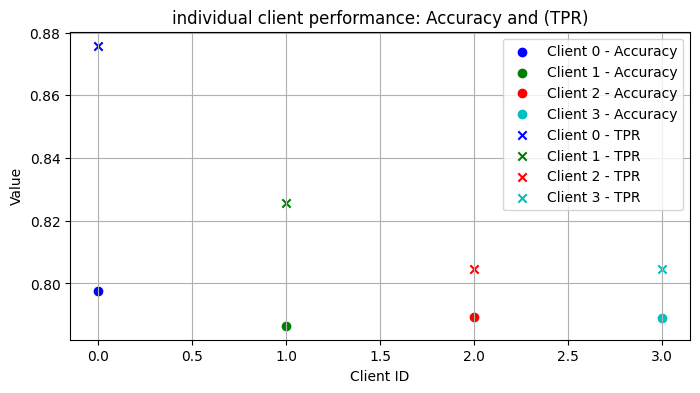

In [32]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('individual client performance: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()